In [1]:
# Data handling
# import pandas as pd
# import numpy as np

# Data visualization
import matplotlib.pyplot as plt
# import seaborn as sns
# from PIL import Image
import cv2

# # Preprocessing
# from sklearn.model_selection import train_test_split
# from collections import Counter

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
# from torchinfo import summary
# from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# 강의 자료
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# os
import os

# Path
from pathlib import Path

# random
import random

# warnings
import warnings
warnings.filterwarnings("ignore")

c:\ProgramData\miniconda3\envs\handletter\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 데이터 호출

In [2]:
# Total Images
IMAGE_PATH = Path(r"C:\Users\USER\Documents\GitHub\DeepLearningHandSign\sign_language\sign_language_images_train")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.png"))

print(f"Total Images = {len(IMAGE_PATH_LIST)}")

Total Images = 21962


In [3]:
# Total Images per class
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Total Images per class")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.png")))
    print(f"* {c} => {imgs_class} images")

************************************************************
                  Total Images per class
************************************************************
* bi => 1750 images
* chi => 1415 images
* di => 1749 images
* hi => 1365 images
* ii => 1750 images
* ji => 1610 images
* ki => 1385 images
* kki => 1455 images
* mi => 1340 images
* ni => 1385 images
* pi => 1750 images
* ri => 1749 images
* si => 1749 images
* ti => 1510 images


In [21]:
# # 이미지 읽기
# img = cv2.imread(r'C:/Users/USER/Documents/GitHub/DeepLearningHandSign/sign_language/sign_language_images_train/ki/ki_1.png', cv2.IMREAD_GRAYSCALE)

# # 이미지가 올바르게 읽혔는지 확인
# if img is None:
#     print("이미지를 읽을 수 없습니다.")
# else:
#     # 이미지를 matplotlib을 사용하여 표시
#     plt.imshow(img, cmap='gray')
#     plt.show()


In [20]:
# # 클래스 리스트
# classes = sorted(os.listdir(IMAGE_PATH))

# # 일부 이미지 표시할 개수
# NUM_IMAGES = 3

# # 서브플롯 생성
# fig, ax = plt.subplots(nrows=len(classes), ncols=NUM_IMAGES, figsize=(10, 24))

# # 각 클래스별로 이미지 표시
# for p, c in enumerate(classes):
#     # 클래스 폴더 내의 이미지 목록 가져오기
#     imgs_total = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.png"))
#     # 무작위로 이미지 선택
#     imgs_selected = random.choices(imgs_total, k=NUM_IMAGES)
    
#     for i, img_select in enumerate(imgs_selected):
#         # 이미지 읽기 및 RGB로 변환
#         img_rgb = cv2.imread(str(img_select))
#         img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
#         # 이미지 표시
#         ax[p, i].imshow(img_rgb)
#         ax[p, i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
#         ax[p, i].axis("off")
        
# # 서브플롯 간 간격 조정
# fig.tight_layout()
# plt.show()


# 모델 설정 - ResNet

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda") # GPU를 device에 넣는다.
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


In [7]:
# sLResNet 클래스 정의
class sLResNet(nn.Module):
    def __init__(self):
        super(sLResNet, self) .__init__()
        # ResNet18 모델 로드
        self.resnet = models.resnet18(weights=None) # torchvision의 models에 resnet18이 있다! 18, 34, 50, 152
        # 출력 레이어를 클래스 수에 맞게 조정 -- 결과 레이블에 맞게 출력 되는 수를 맞추는 것
        num_ftrs = self.resnet.fc.in_features # 맨 마지막 레이어 특징 추출 레이어에서
        self.resnet.fc = nn.Linear(num_ftrs, 14) # 총 14개이니, 14개로 수정, 꼭 맞춰줘야 한다.

    def forward(self, x):
        return self.resnet(x)

##### 데이터셋 정의

In [8]:
from PIL import Image # 이미지 경로를 cv2로 imread로 한 후 PIL 이미지로 변환해야 한다.

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR을 RGB로 변환
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환, 매우 중요!!!


        # 이미지 변환 적용
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

## 학습, 평가 데이터 이미지경로 호출

In [9]:
def find_images(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):
                image_paths.append(os.path.join(root, file))
    return image_paths

# 이미지가 있는 디렉토리 경로
image_dir_train = r'C:\Users\USER\Documents\GitHub\OpenCV_study\sign_language\sign_language_images_train'
image_dir_test = r'C:\Users\USER\Documents\GitHub\OpenCV_study\sign_language\sign_language_images_test'

# 모든 이미지 파일의 경로 찾기
image_paths_train = find_images(image_dir_train)
image_paths_test = find_images(image_dir_test)

# 찾은 이미지 파일의 경로 출력
print(len(image_paths_train))
print(len(image_paths_test))
# train_image_paths

21962
3790


## 학습, 평가 데이터 target 데이터 설정

In [10]:
# # 이미지 파일 경로에서 레이블 추출
def extract_label_from_path(image_path):
    return os.path.basename(os.path.dirname(image_path))

def create_labels(image_paths):
    labels = [extract_label_from_path(image_path) for image_path in image_paths]
    return labels

# 이미지 파일의 경로로부터 레이블 생성
labels_train = create_labels(image_paths_train)
print(labels_train)
labels_test = create_labels(image_paths_test)

['bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi', 'bi

In [11]:
def convert_labels(label_list):
    label_to_number = {
        'ki': 0, 'ni': 1, 'di': 2, 'ri': 3, 'mi': 4,
        'bi': 5, 'si': 6, 'ii': 7, 'ji': 8, 'chi': 9,
        'kki': 10, 'ti': 11, 'pi': 12, 'hi': 13
    }
    return [label_to_number.get(label, label) for label in label_list]

# 예시: label_list가 ['ki', 'ni', 'ji']이면 [0, 1, 8]을 반환
# label_list가 ['ki', '~hi']이면 [0, 13]을 반환

labels_train = convert_labels(labels_train)
labels_test = convert_labels(labels_test)
print("변환된 리스트:", labels_test)

변환된 리스트: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [12]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [13]:
# 데이터셋 생성
train_dataset = CustomImageDataset(image_paths_train, labels_train, transform=transform)
test_dataset = CustomImageDataset(image_paths_test, labels_test, transform=transform)


## 데이터 로드

In [14]:
# 데이터셋 사용하여 데이터 로드
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 모델 생성
## 학습률, 모멘텀 설정

In [15]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = sLResNet().to(device) # ResNet 인스턴스를 생성하고 GPU에 올린다.
criterion = nn.CrossEntropyLoss() # 손실함수, 오차
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.5) # SGD 학습에 가속도를 준다. 가중치 변화를 0.5 모멘텀을 더 더해서 변화하게 하자. 끼익 하고 밀리게
# optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.5)

In [16]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [17]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0 # 정답 횟수
    total = 0 # 전체 개수
    for data, target in train_loader:
        if torch.cuda.is_available(): # GPU 사용이 가능하다면
            data, target = data.to(device), target.to(device) #GPU로 돌려줘
        # print(data, '데이터')
        # print(target, '타겟')
        optimizer.zero_grad()
        output = model(data)
        # print(output, '아웃풋')
        # print(output.shape, '아웃풋 모양')
        # print(target.shape, '타겟 모양')
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print (f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    # train_accuracies.append(train_accuracies) # 정확도 기록을 위한 리스트에 추가
    train_accuracies.append(accuracy) # 정확도 기록을 위한 리스트에 추가

In [18]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [19]:
# 훈련 및 테스트 실행
for epoch in range(1, 5):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 0.1693
Test loss: 0.0107, Accuracy: 99.97%
Epoch 2, Training loss: 0.0075
Test loss: 0.0044, Accuracy: 100.00%
Epoch 3, Training loss: 0.0035
Test loss: 0.0025, Accuracy: 100.00%
Epoch 4, Training loss: 0.0023
Test loss: 0.0019, Accuracy: 100.00%


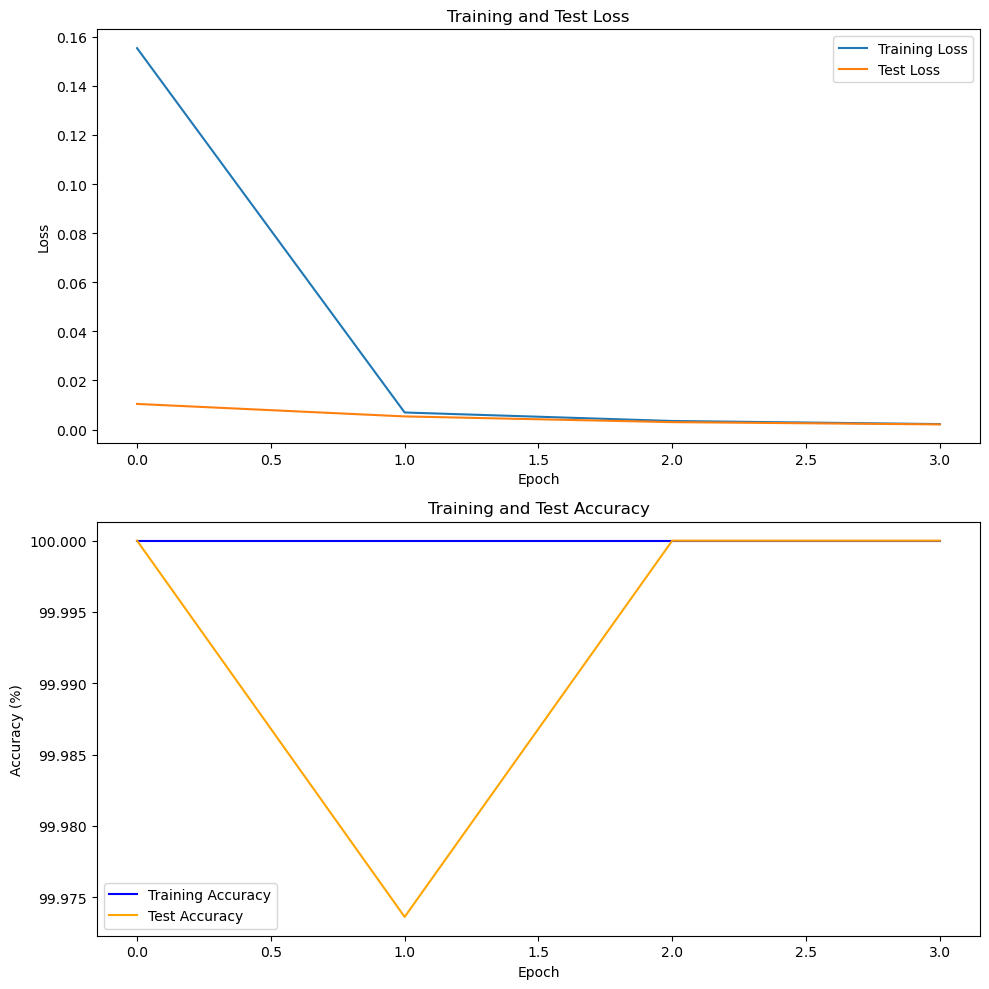

In [21]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

### 하이퍼 파라미터는 무슨 무슨 종류가 있나?

In [57]:
# 무작위로 선택된 10개의 이미지에 대한 예측 수행
def predict_random_samples(model, dataset, num_samples=10):
    model.eval()
    random_indices = random.sample(range(len(dataset)), num_samples)
    predictions = []
    targets = []
    with torch.no_grad():
        for index in random_indices:
            image, target = dataset[index]
            image = image.unsqueeze(0)  # 배치 차원을 추가
            image = image.to(device)  # GPU로 이동
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            predictions.append(predicted.item())
            targets.append(target)
    return random_indices, predictions, targets

findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not found.
findfont: Font family 'malgun' not

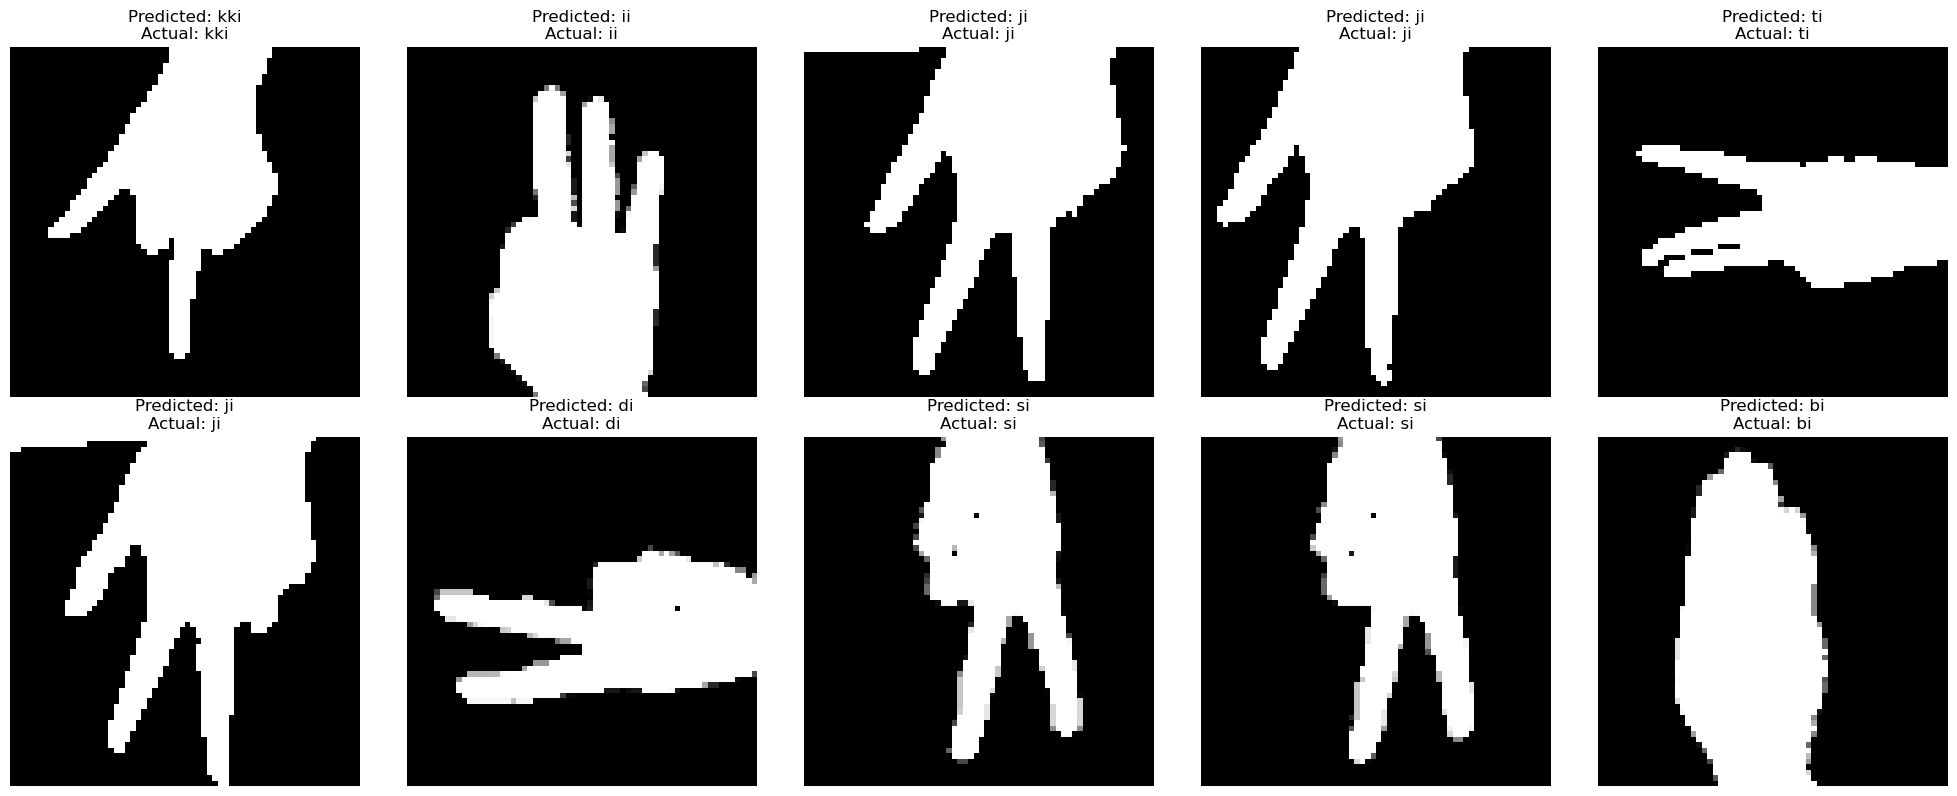

In [59]:
# -*- coding: utf-8 -*-

# 레이블을 문자열로 변환하는 함수
def convert_label_to_string(label):
    label_to_string = {
        0: 'ki', 1: 'ni', 2: 'di', 3: 'ri', 4: 'mi',
        5: 'bi', 6: 'si', 7: 'ii', 8: 'ji', 9: 'chi',
        10: 'kki', 11: 'ti', 12: 'pi', 13: 'hi'
    }
    return label_to_string.get(label, label)

# 예측 결과 얻기
random_indices, predictions, targets = predict_random_samples(model, test_dataset)

# 서브 플롯으로 결과 시각화
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for ax, index, prediction, target in zip(axes, random_indices, predictions, targets):
    image_path = image_paths_test[index]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    # 예측 결과와 실제 레이블을 해당 문자열로 변환하여 출력
    pred_label_str = convert_label_to_string(prediction)
    target_label_str = convert_label_to_string(target)
    ax.set_title(f"Predicted: {pred_label_str}\nActual: {target_label_str}")
    ax.axis("off")

plt.tight_layout()
plt.show()